# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import pickle
import torch
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import itertools

from src.dcits import DCITSOrder3
from src.utils import model_data_from_time_series,get_data_loaders_and_eval_datasets,train_model,evaluate_model,TimeSeriesDataset

In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Specify the device as the second GPU
    device = torch.device("cuda:0")
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")

In [5]:
seed=1000
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Prepare dataset

In [6]:
mean=0
std=0.1
frequency=0.3
max_lag=10

window_len=5
num_of_timeseries=3
remove_first=100
batch_size=128

In [7]:
def cubic_map(len_of_timeseries,a,noise_frequency=0,sigma=1):
        
    time_series=torch.empty((3,len_of_timeseries)).uniform_(-0.9999,0.9999)
    for i in range(5,len_of_timeseries):
        add_gaussian_noise=False
        if np.random.random()>(1-noise_frequency):
            add_gaussian_noise=True
        time_series[0,i]=a*time_series[0,i-3]*time_series[0,i-3]*time_series[0,i-3] + (1-a)*time_series[0,i-3]
        time_series[0,i]=(time_series[0,i] + add_gaussian_noise*np.random.normal(0,sigma))
        
        time_series[1,i]=a*time_series[1,i-5]*time_series[1,i-5]*time_series[1,i-5] + (1-a)*time_series[1,i-5]
        time_series[1,i]=(time_series[1,i] + add_gaussian_noise*np.random.normal(0,sigma))
        
        time_series[2,i]=(time_series[0,i-3] + time_series[1,i-5])/2 
        time_series[2,i]=(time_series[2,i] + add_gaussian_noise*np.random.normal(0,sigma))
        
    return time_series

In [8]:
X=[]
y=[]
for i in range(20):
    r=3.75
    time_series=cubic_map(1000,r,noise_frequency=0)

    time_series=time_series[:,remove_first:]
    
    num_of_timeseries,len_of_timeseries=time_series.shape
    num_of_examples=len_of_timeseries-window_len

    X_ex=torch.empty((num_of_examples,1,num_of_timeseries,window_len)).normal_(mean=0,std=1)
    y_ex=torch.zeros(num_of_examples,num_of_timeseries)

    for i in range(0,num_of_examples):
        X_ex[i,0,:,:]=time_series[:,i:(i+window_len)]
        y_ex[i,:]=time_series[:,i+window_len]
    
    X.append(X_ex)
    y.append(y_ex)
    
X=torch.concat(X)
y=torch.concat(y)

X = X.to(device)
y = y.to(device)

In [9]:
model=DCITSOrder3(num_of_timeseries,window_len,in_ch=16,temp=1)
model=model.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)

In [10]:
train_one_epoch, valid_one_epoch, test_dataset=get_data_loaders_and_eval_datasets(X,y,optimizer,loss_fn,batch_size=batch_size)

In [11]:
model=train_model(model,train_one_epoch,valid_one_epoch,epochs=10,enable_writer=False,save_model=False)

Epoch 1/10
  Training Loss: 0.00030086
  Validation Loss: 0.00135469
Epoch 2/10
  Training Loss: 0.00000184
  Validation Loss: 0.00001853
Epoch 3/10
  Training Loss: 0.00000136
  Validation Loss: 0.00001387
Epoch 4/10
  Training Loss: 0.00000081
  Validation Loss: 0.00000805
Epoch 5/10
  Training Loss: 0.00000058
  Validation Loss: 0.00000599
Epoch 6/10
  Training Loss: 0.00000045
  Validation Loss: 0.00000476
Epoch 7/10
  Training Loss: 0.00000037
  Validation Loss: 0.00000375
Epoch 8/10
  Training Loss: 0.00000034
  Validation Loss: 0.00000324
Epoch 9/10
  Training Loss: 0.00000029
  Validation Loss: 0.00000338
Epoch 10/10
  Training Loss: 0.00000076
  Validation Loss: 0.00000826


In [12]:
idx = test_dataset.indices
x = test_dataset.dataset.X[idx]
y_truth = test_dataset.dataset.y[idx]
y_predict, f, (c1,c2,c3) = model(x)

Text(0.5, 0, 'y')

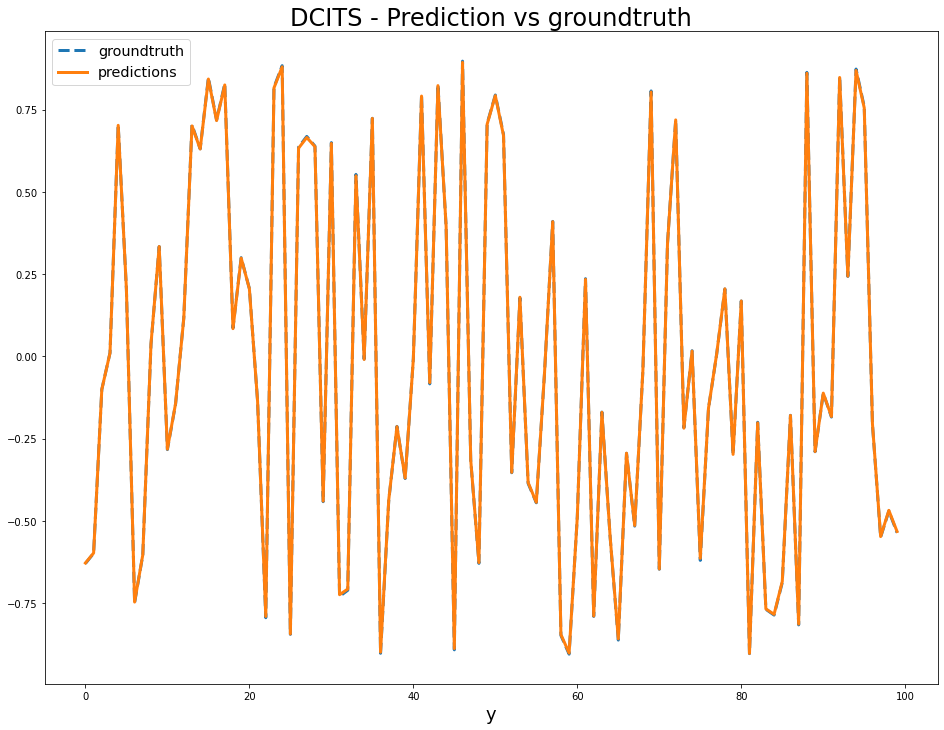

In [13]:
plt.figure(figsize=(16,12))
plt.plot(y_truth.detach().cpu().numpy()[:100,1],label='groundtruth',linewidth=3,linestyle='--')
plt.plot(y_predict.detach().cpu().numpy()[:100,1],label='predictions',linewidth=3,linestyle='-')
plt.legend(fontsize='x-large')
plt.title('DCITS - Prediction vs groundtruth',fontsize=24)
plt.xlabel('t',fontsize=18)
plt.xlabel('y',fontsize=18)

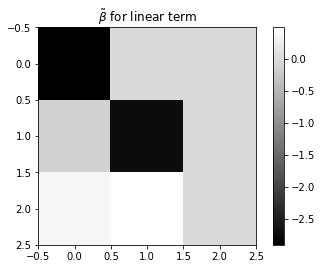

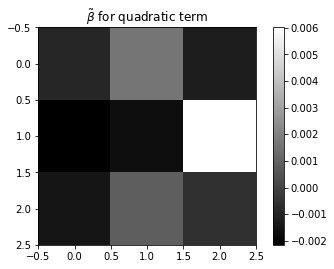

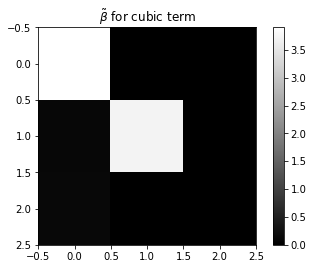

In [14]:
plt.imshow((f*c1).mean(0).sum(2).detach().cpu().numpy(),cmap=plt.cm.binary_r)
plt.title(r'$\tilde{\beta}$ for linear term' )
plt.colorbar()
plt.show()
plt.imshow((f*c2).mean(0).sum(2).detach().cpu().numpy(),cmap=plt.cm.binary_r)
plt.title(r'$\tilde{\beta}$ for quadratic term' )
plt.colorbar()
plt.show()
plt.imshow((f*c3).mean(0).sum(2).detach().cpu().numpy(),cmap=plt.cm.binary_r)
plt.title(r'$\tilde{\beta}$ for cubic term' )
plt.colorbar()
plt.show()

In [15]:
def calculate_forward_manually(x,f,c1=None,c2=None,c3=None):
    """
    This function is used to iterate over different combinations.
    """
    if c1==None:
        c1=0
    if c2==None:
        c2=0
    if c3==None:
        c3=0
    x=x*f*c1 + x*x*f*c2 + x*x*x*f*c3
    x=x.sum(dim=(2,3))
    return x

In [16]:
aic_dict=dict()
param_len = 3

idx = test_dataset.indices
x = test_dataset.dataset.X[idx]
y_truth = test_dataset.dataset.y[idx]

param_combinations = list(itertools.product([0, 1], repeat=param_len))
for combo_index, combo in enumerate(param_combinations):
    _ , f, (c1, c2, c3) = model(x)
    
    # Apply combination multipliers
    c1 = c1 * combo[0]
    c2 = c2 * combo[1]
    c3 = c3 * combo[2]
    
    # Recalculate outputs with modified parameters
    outputs = calculate_forward_manually(x, f, c1, c2, c3)
    
    # Compute the loss for the entire dataset
    vloss = loss_fn(outputs, y_truth)
    
    SSE = vloss.detach().cpu().numpy()  # Sum of squared errors
    n = len(y_truth)/batch_size
    p = 2 + (sum(combo) + 1)
    SBC = round(n * np.log(SSE / n) + p * np.log(n), 2)
    AIC = round(n * np.log(SSE / n) + 2 * p, 2)
    AICc = round(n * np.log(SSE / n) + (n + p) / (1 - (p + 2) / n), 2)
    aic_dict[combo_index] = (combo,AIC)

In [17]:
aic_dict

{0: ((0, 0, 0), -48.64),
 1: ((0, 0, 1), -20.78),
 2: ((0, 1, 0), -46.64),
 3: ((0, 1, 1), -18.78),
 4: ((1, 0, 0), -26.2),
 5: ((1, 0, 1), -192.12),
 6: ((1, 1, 0), -24.2),
 7: ((1, 1, 1), -188.88)}

In [19]:
# Initialize variables to store the minimum AIC and its corresponding combo index
min_aic = float('inf')
min_combo = None

# Iterate over the aic_dict to find the smallest AIC value
for _, (combo, AIC) in aic_dict.items():
    if AIC < min_aic:
        min_aic = AIC
        min_combo = combo

# Print the combo index with the smallest AIC value
print(f"The combo index with the smallest AIC value is: {min_combo}")
print(f"The corresponding AIC value is: {min_aic}")

The combo index with the smallest AIC value is: (1, 0, 1)
The corresponding AIC value is: -192.12
